In [1]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx
import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt

In [2]:
torch.cuda.is_available()

False

In [3]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    return [(i, j) for i in range(size) for j in range(i + 1, size)]

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        d = path_length[i[0]][i[1]]
        l = L * d #l = L * d
        k = K/(d**2) 
        edge_attr.append([l,k])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size, file_name):
    while True:
        G = nx.binomial_graph(size, random.random(),directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
        nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 16, Linear(2, 2*16))
#         self.conv2 = NNConv(16, 32, Linear(2, 16*32))
#         self.conv3 = NNConv(32, 64, Linear(2, 32*64))
#         self.conv4 = NNConv(16+32+64, 2, Linear(2, (16+32+64)*2))
        self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = F.relu(self.conv1(x, edge_index, edge_attr))
        x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
#         x = torch.cat((x1, x2, x3), dim=1)
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
        
        return x2

class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data_batch):
        energy = 0
        offset = 0
        for data in data_batch.to_data_list():
            edge_attr = data.edge_attr
            n = data.x.size()[0]
            x = p[offset:offset+n, 0]
            y = p[offset:offset+n, 1]
            offset += n
            l = edge_attr[:, 0]
            k = edge_attr[:, 1]
            for e, (i, j) in enumerate(generate_edgelist(n)):
                term1 = (x[i] - x[j]) ** 2
                term2 = (y[i] - y[j]) ** 2
                term3 = l[e] ** 2
                term4 = 2 * l[e] * (term1 + term2).sqrt()
                energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy
    
def train(model, criterion, optimizer,loader):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(data_list)

def evaluate(model,data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach().cpu().numpy()
    return pred


def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        G.nodes[i]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 

In [16]:
ngraph = 5000
ngraph_size = [random.randint(5,20) for i in range(ngraph)]
data_list = []
for i in range(ngraph):
    G, data = generate_graph(ngraph_size[i], f'random_graph/{i}.txt')
    data_list.append(data)

1 43735.919803125
2 10945.08476328125
3 3910.3935521484377
4 1961.5876291015625
5 1258.792574609375
6 932.5490141601563
7 760.5107155273438
8 653.571962890625
9 585.4087046875
10 536.862277734375
11 502.705755078125
12 474.23677890625
13 452.71488544921874
14 435.036874609375
15 422.85501005859373
16 411.5949626953125
17 404.7069431640625
18 397.63785966796877
19 391.26184609375
20 385.9680162109375


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 383.08597783203123
22 379.3451140625
23 376.66333447265623
24 374.6326897460938
25 370.9778998046875
26 370.50293359375
27 369.4647263671875
28 368.1841673828125
29 367.09708798828126
30 366.4666720703125
31 364.23438046875
32 365.0351521484375
33 364.20149951171874


KeyboardInterrupt: 

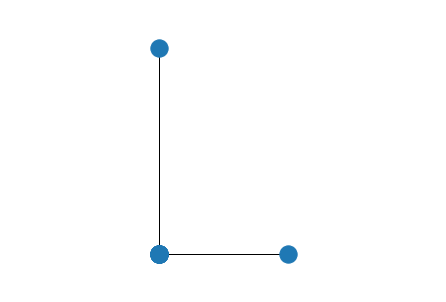

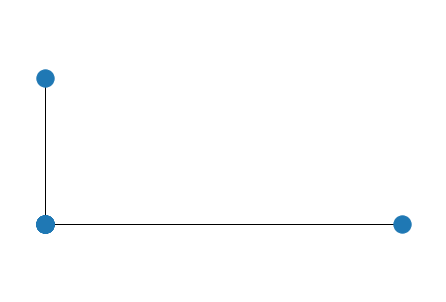

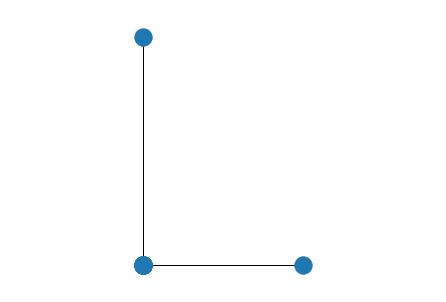

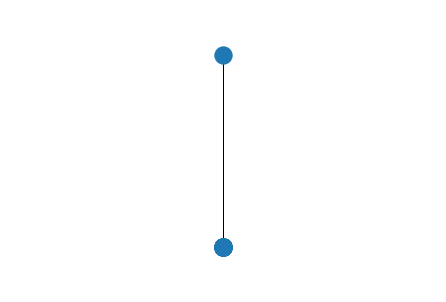

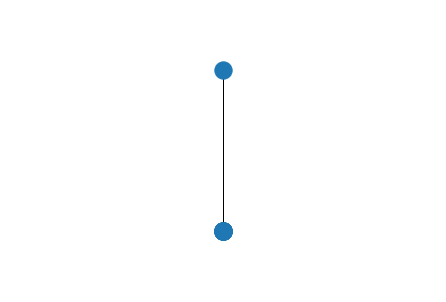

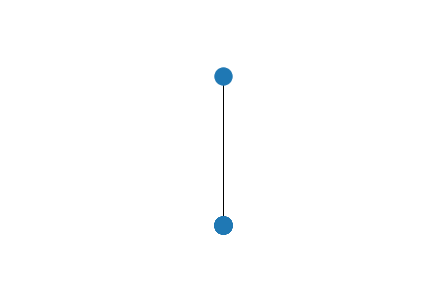

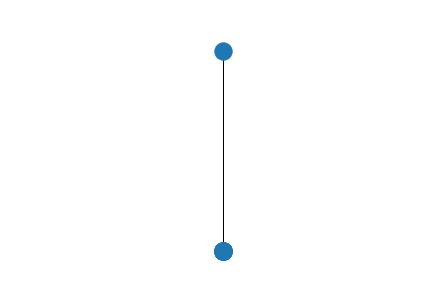

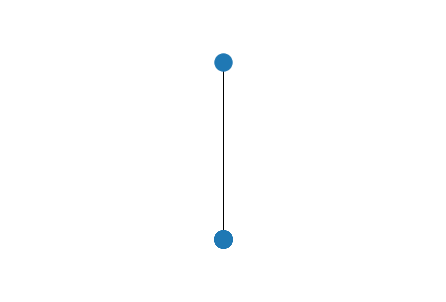

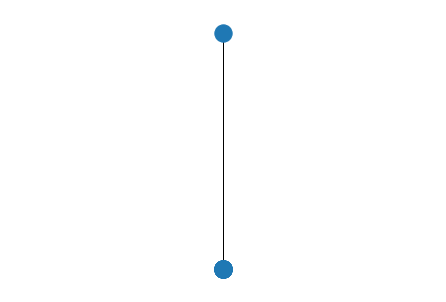

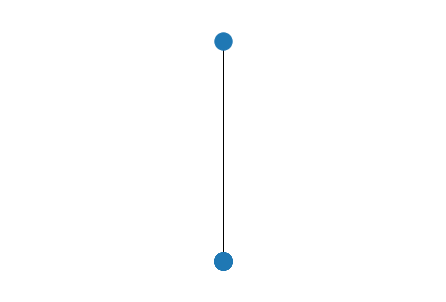

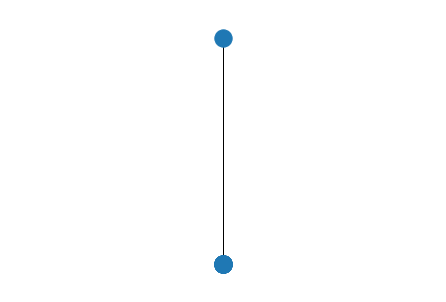

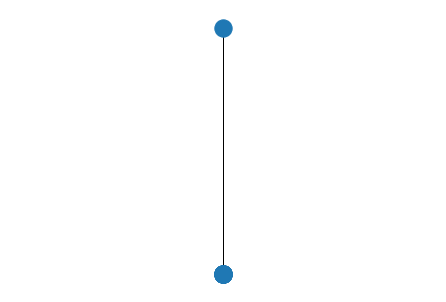

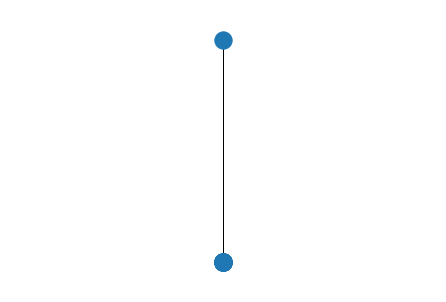

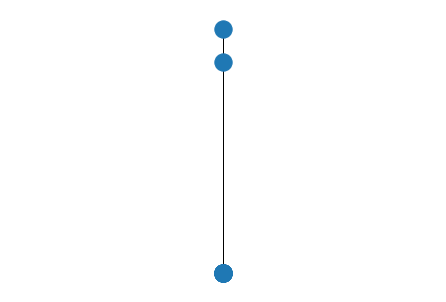

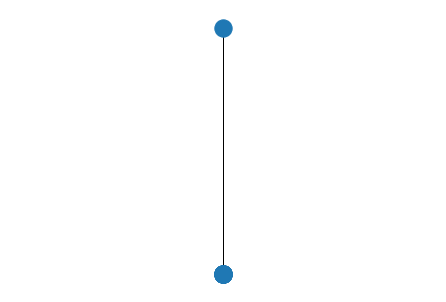

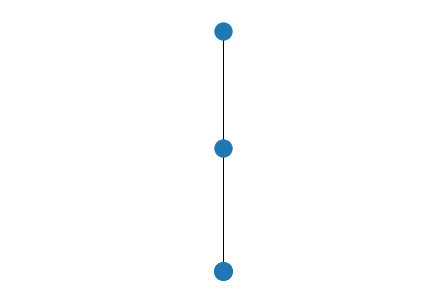

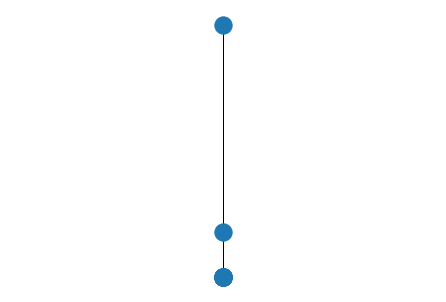

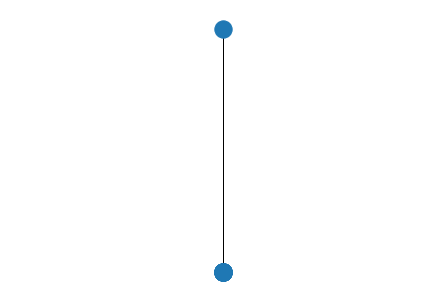

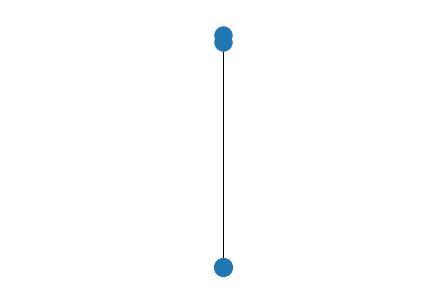

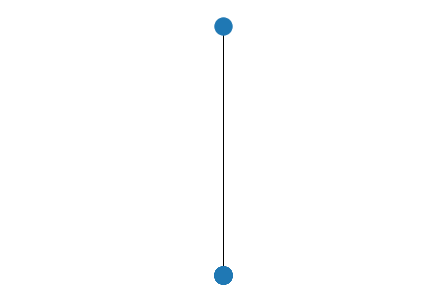

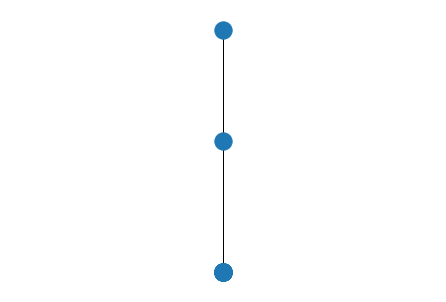

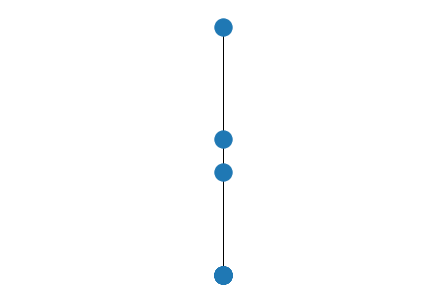

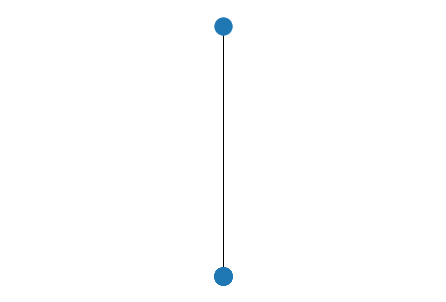

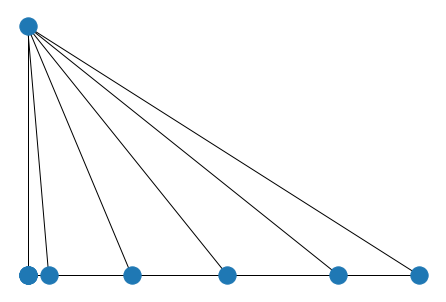

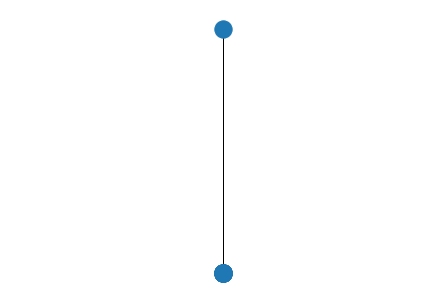

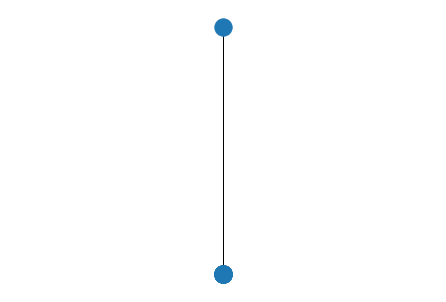

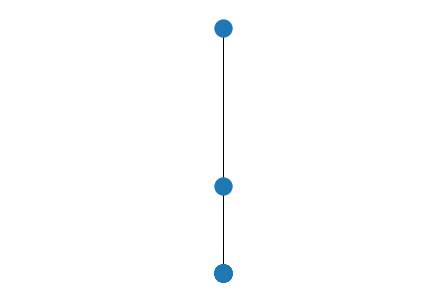

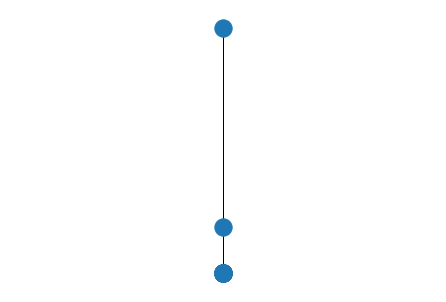

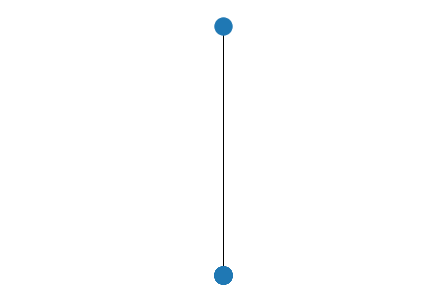

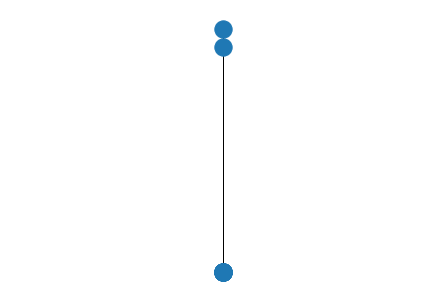

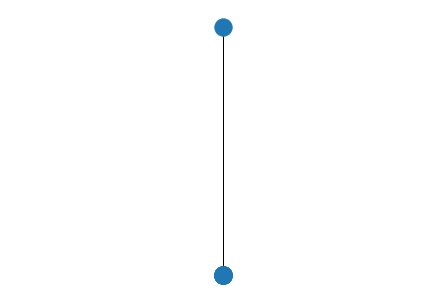

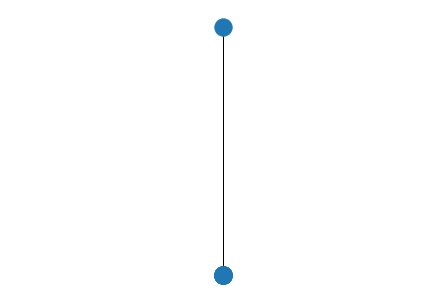

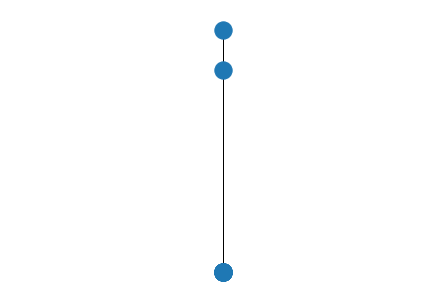

In [17]:
loader = DataLoader(data_list[:2000], batch_size=32,shuffle=True)
start_epoch = 1
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if start_epoch == 1:
    model = Net().to(device)
else:
    model = torch.load(f'ckpt/epoch_{start_epoch}.pt').to(device)
criterion = EnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_ep = []
for epoch in range(start_epoch, num_epochs):
    loss = train(model, criterion, optimizer,loader)
    loss_ep.append(loss)
    if epoch % 1 == 0:
        torch.save(model, f'ckpt/epoch_{epoch}.pt')
        G, data = generate_graph(10, f'test/epoch_{epoch}.txt')
        node_pos = evaluate(model, data)
        graph_vis(G, node_pos, f'test/epoch_{epoch}.png')
    print(epoch, loss)

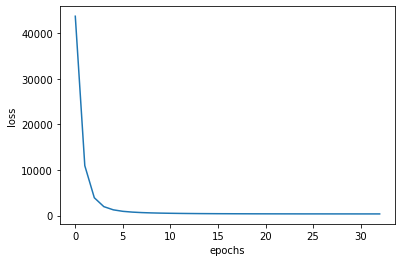

In [18]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep)
plt.show()